<a href="https://colab.research.google.com/github/satya29m3/self-driving-car/blob/master/udacity_self_driving_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/satya29m3/track.git

Cloning into 'track'...
remote: Enumerating objects: 15811, done.
remote: Counting objects: 100% (15811/15811), done.
remote: Compressing objects: 100% (15811/15811), done.
remote: Total 15811 (delta 0), reused 15811 (delta 0), pack-reused 0
Receiving objects: 100% (15811/15811), 201.75 MiB | 33.26 MiB/s, done.
Checking out files: 100% (15808/15808), done.


In [0]:
!pip3 install imgaug

In [0]:
!ls track

driving_log.csv  IMG


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D,Dense,Dropout,MaxPooling2D,Flatten
import cv2
import ntpath
import random
from imgaug import augmenters as iaa
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from matplotlib import image as mpimg


Using TensorFlow backend.


In [0]:
datadir = 'track'
columns =['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'),names = columns)
pd.set_option('display.max_colwidth',-1)
data.head()

center  ...     speed
0  /home/satya/Downloads/self drivnig car/IMG/center_2019_06_20_11_21_33_796.jpg  ...  0.000081
1  /home/satya/Downloads/self drivnig car/IMG/center_2019_06_20_11_21_33_912.jpg  ...  0.000079
2  /home/satya/Downloads/self drivnig car/IMG/center_2019_06_20_11_21_34_026.jpg  ...  0.000081
3  /home/satya/Downloads/self drivnig car/IMG/center_2019_06_20_11_21_34_155.jpg  ...  0.000078
4  /home/satya/Downloads/self drivnig car/IMG/center_2019_06_20_11_21_34_271.jpg  ...  0.124372

[5 rows x 7 columns]

In [0]:
def path_leaf(path):
  head,tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2019_06_20_11_21_33_796.jpg  ...  0.000081
1  center_2019_06_20_11_21_33_912.jpg  ...  0.000079
2  center_2019_06_20_11_21_34_026.jpg  ...  0.000081
3  center_2019_06_20_11_21_34_155.jpg  ...  0.000078
4  center_2019_06_20_11_21_34_271.jpg  ...  0.124372

[5 rows x 7 columns]

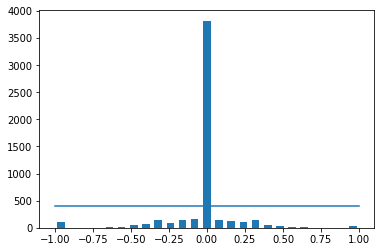

In [0]:
num_bins =25
samples_per_bin =400
hist, bins = np.histogram(data['steering'],num_bins)
center = (bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width = 0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))
#print(hist)

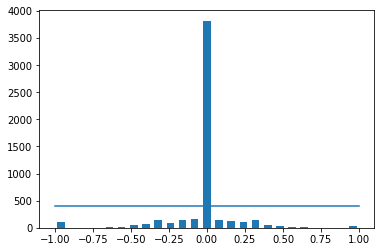

In [0]:
hist , _ = np.histogram(data['steering'], num_bins)
plt.bar(center , hist , width = 0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [0]:
print('total data', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <=bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
print(len(data['steering'])-len(remove_list))
data.drop(data.index[remove_list],inplace =True)
print('real' , data)




total data 5269
1849
real                                   center  ...      speed
8     center_2019_06_20_11_21_34_675.jpg  ...  3.976671 
10    center_2019_06_20_11_21_34_894.jpg  ...  6.524229 
11    center_2019_06_20_11_21_35_009.jpg  ...  7.846371 
12    center_2019_06_20_11_21_35_109.jpg  ...  8.976799 
15    center_2019_06_20_11_21_35_442.jpg  ...  12.523650
16    center_2019_06_20_11_21_35_542.jpg  ...  13.516150
20    center_2019_06_20_11_21_35_975.jpg  ...  18.156630
21    center_2019_06_20_11_21_36_076.jpg  ...  18.962860
23    center_2019_06_20_11_21_36_294.jpg  ...  21.281760
24    center_2019_06_20_11_21_36_409.jpg  ...  22.421960
26    center_2019_06_20_11_21_36_626.jpg  ...  24.346750
27    center_2019_06_20_11_21_36_726.jpg  ...  25.180680
28    center_2019_06_20_11_21_36_843.jpg  ...  25.942950
29    center_2019_06_20_11_21_36_943.jpg  ...  26.527380
30    center_2019_06_20_11_21_37_044.jpg  ...  27.482660
31    center_2019_06_20_11_21_37_160.jpg  ...  28.655480
33   

In [0]:
def load_img_steer(datadir , df):
  img_path = []
  steering = []
  for i in range(len(data)):
    ind_data = data.iloc[i]
    center , left , right = ind_data[0], ind_data[1], ind_data[2]
    img_path.append(os.path.join(datadir,center.strip()))
    steering.append(ind_data[3])
  img_path = np.asarray(img_path)
  steering = np.asarray(steering)
  return img_path,steering

img_path , steering = load_img_steer(datadir + '/IMG' , data)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(img_path , steering , test_size = 0.3, random_state = 6)
print('traing samples: {}\nvalid samples:{}'.format(len(y_train),len(y_valid)))

traing samples: 1294
valid samples:555


In [0]:
print(X_train.shape)

(1294,)


Text(0.5, 1.0, 'valid set')

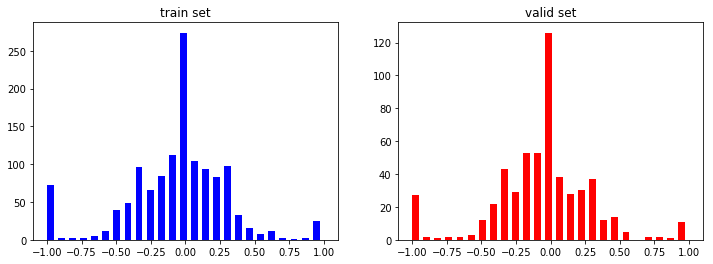

In [0]:
fig ,axs = plt.subplots(1,2,figsize = (12,4))
axs[0].hist(y_train,bins =num_bins,width = 0.05 ,color = 'blue')
axs[0].set_title('train set')
axs[1].hist(y_valid,bins =num_bins,width = 0.05 ,color = 'red')
axs[1].set_title('valid set')

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale = (1,1.3))
  image = zoom.augment_image(image)
  return image

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[[[151 185 226]\n  [152 184 226]\n  [153 183 226]\n  ...\n  [132 168 216]\n  [134 168 218]\n  [138 169 221]]\n\n [[151 186 229]\n  [152 185 229]\n  [153 185 229]\n  ...\n  [131 166 215]\n  [145 178 229]\n  [144 177 228]]\n\n [[151 187 233]\n  [152 186 233]\n  [153 185 233]\n  ...\n  [130 165 215]\n  [138 171 222]\n  [137 169 220]]\n\n ...\n\n [[135 120 101]\n  [138 123 104]\n  [139 124 105]\n  ...\n  [  5  13  16]\n  [  5  13  16]\n  [  5  13  16]]\n\n [[136 121 101]\n  [137 122 102]\n  [135 119  99]\n  ...\n  [  5  13  16]\n  [  5  13  16]\n  [  5  13  16]]\n\n [[135 120  99]\n  [132 116  95]\n  [126 109  89]\n  ...\n  [  5  13  16]\n  [  5  13  16]\n  [  5  13  16]]]')

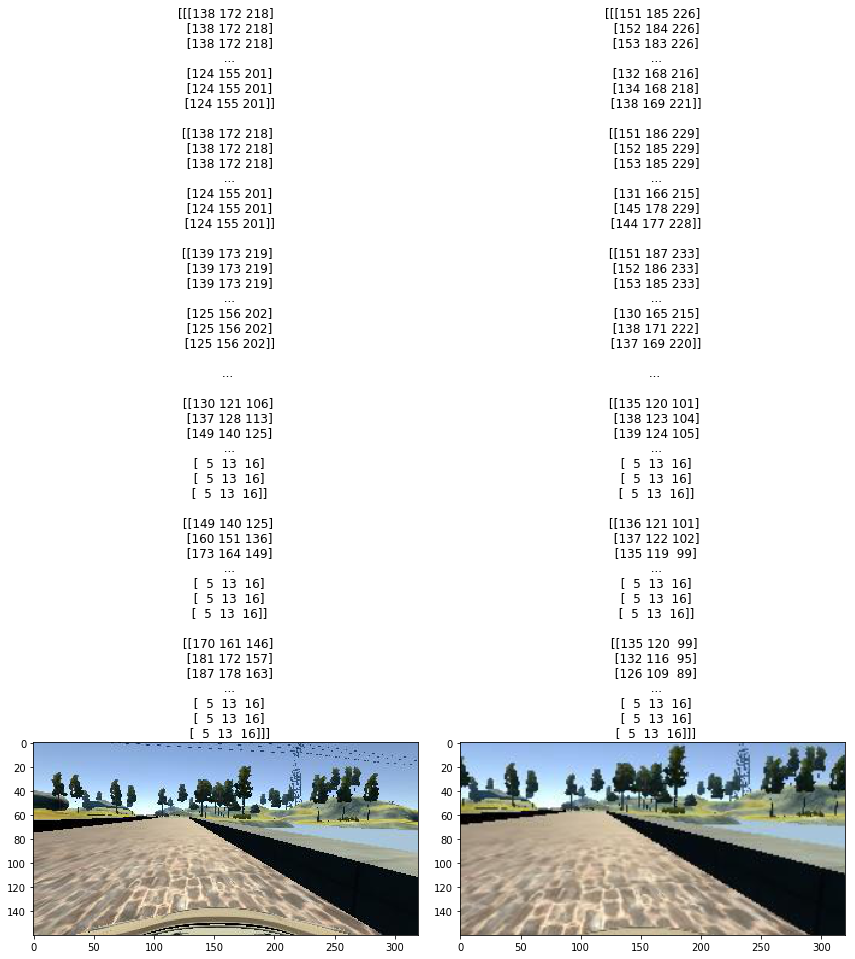

In [0]:
image = img_path[random.randint(0,1000)]
orig = mpimg.imread(image)

zom = zoom(orig)


fig,axs = plt.subplots(1,2, figsize = (12,4))
fig.tight_layout()
axs[0].imshow(orig)
axs[0].set_title(orig)
axs[1].imshow(zom)
axs[1].set_title(zom)




In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent  = {'x':(-0.1,0.1),'y':(-0.1,0.1)})
  image = pan.augment_image(image)
  return image

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[[[  0   0   0]\n  [  0   0   0]\n  [142 174 221]\n  ...\n  [ 42  47  17]\n  [ 60  64  47]\n  [ 28  33  26]]\n\n [[  0   0   0]\n  [  0   0   0]\n  [142 174 221]\n  ...\n  [ 46  51  21]\n  [ 57  64  46]\n  [  6  13   5]]\n\n [[  0   0   0]\n  [  0   0   0]\n  [144 176 223]\n  ...\n  [ 37  44  13]\n  [ 33  40  22]\n  [  9  16   8]]\n\n ...\n\n [[  0   0   0]\n  [  0   0   0]\n  [  0   0   0]\n  ...\n  [  0   0   0]\n  [  0   0   0]\n  [  0   0   0]]\n\n [[  0   0   0]\n  [  0   0   0]\n  [  0   0   0]\n  ...\n  [  0   0   0]\n  [  0   0   0]\n  [  0   0   0]]\n\n [[  0   0   0]\n  [  0   0   0]\n  [  0   0   0]\n  ...\n  [  0   0   0]\n  [  0   0   0]\n  [  0   0   0]]]')

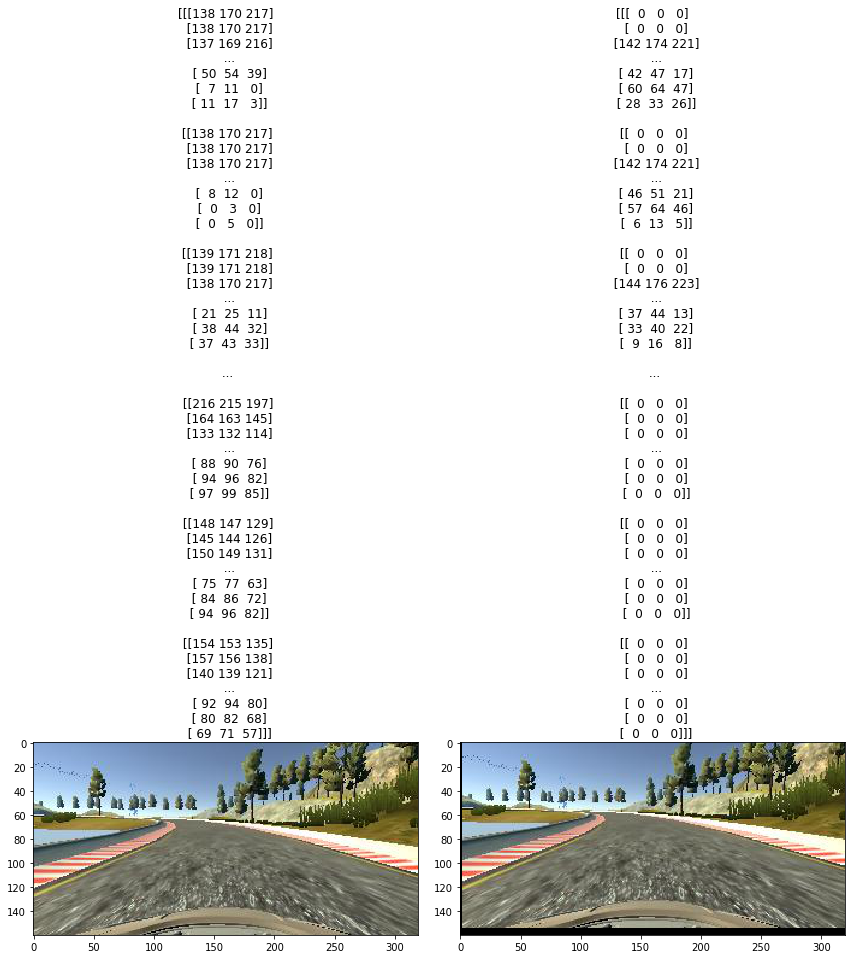

In [0]:
image = img_path[random.randint(0,1000)]
orig = mpimg.imread(image)

pn = pan(orig)


fig,axs = plt.subplots(1,2, figsize = (12,4))
fig.tight_layout()
axs[0].imshow(orig)
axs[0].set_title(orig)
axs[1].imshow(pn)
axs[1].set_title(pn)

In [0]:
def img_preprocess(img):
#   img = mpimg.imread(img)
  img = img[60:135, :, :]
  img = cv2.cvtColor(img , cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,(3,3),0)
  img = cv2.resize(img , (200,66))
  img = img/255
  return img

# image = img_path[300]
# orig_img = mpimg.imread(image)
# preprocessed = img_preprocess(image)
# fig ,axs = plt.subplots(1,2,figsize=(12,4))
# fig.tight_layout()
# axs[0].imshow(orig_img)
# axs[0].set_title('orig')
# axs[1].imshow(preprocessed)
# axs[1].set_title('prepro')

In [0]:
def brightness(image):
  brit = iaa.Multiply((0.2,1.2))
  image = brit.augment_image(image)
  return image

Text(0.5, 1.0, 'brit')

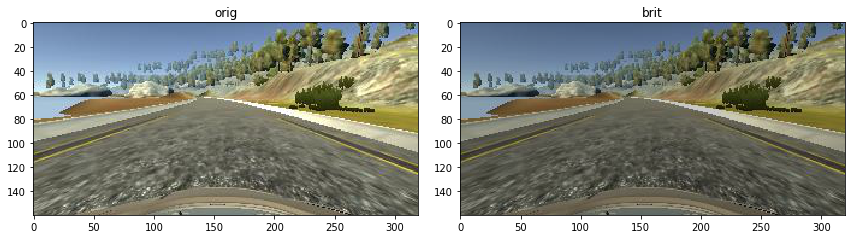

In [0]:
image = img_path[300]
orig_img = mpimg.imread(image)
brit = brightness(orig_img)
fig ,axs = plt.subplots(1,2,figsize=(12,4))
fig.tight_layout()
axs[0].imshow(orig_img)
axs[0].set_title('orig')
axs[1].imshow(brit)
axs[1].set_title('brit')

In [0]:
def random_flip(image,steering):
  image = cv2.flip(image,1)
  steering = -steering
  return image,steering
  

Text(0.5, 1.0, 'flipped-0.3047698')

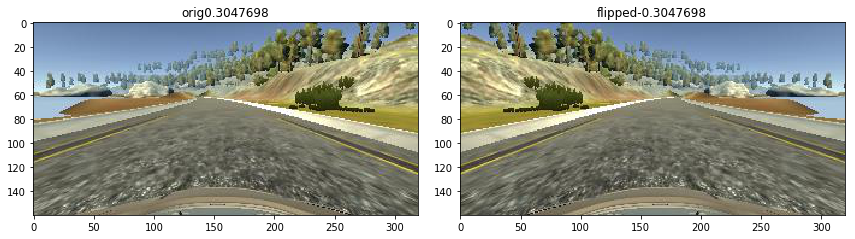

In [0]:
image = img_path[300]
steer = steering[300]
orig_img = mpimg.imread(image)
flipped , steeri = random_flip(orig_img,steer)
fig ,axs = plt.subplots(1,2,figsize=(12,4))
fig.tight_layout()
axs[0].imshow(orig_img)
axs[0].set_title('orig' + str(steer))
axs[1].imshow(flipped)
axs[1].set_title('flipped' + str(steeri))

In [0]:
def random_augment(image,steer):
  image = mpimg.imread(image)
  if np.random.rand()<0.5:
    image = pan(image)
  if np.random.rand()<0.5:
    image = zoom(image)
  if np.random.rand()<0.5:
    image = brightness(image)
  if np.random.rand()<0.5:
    image, steer = random_flip(image,steer)
  return image,steer

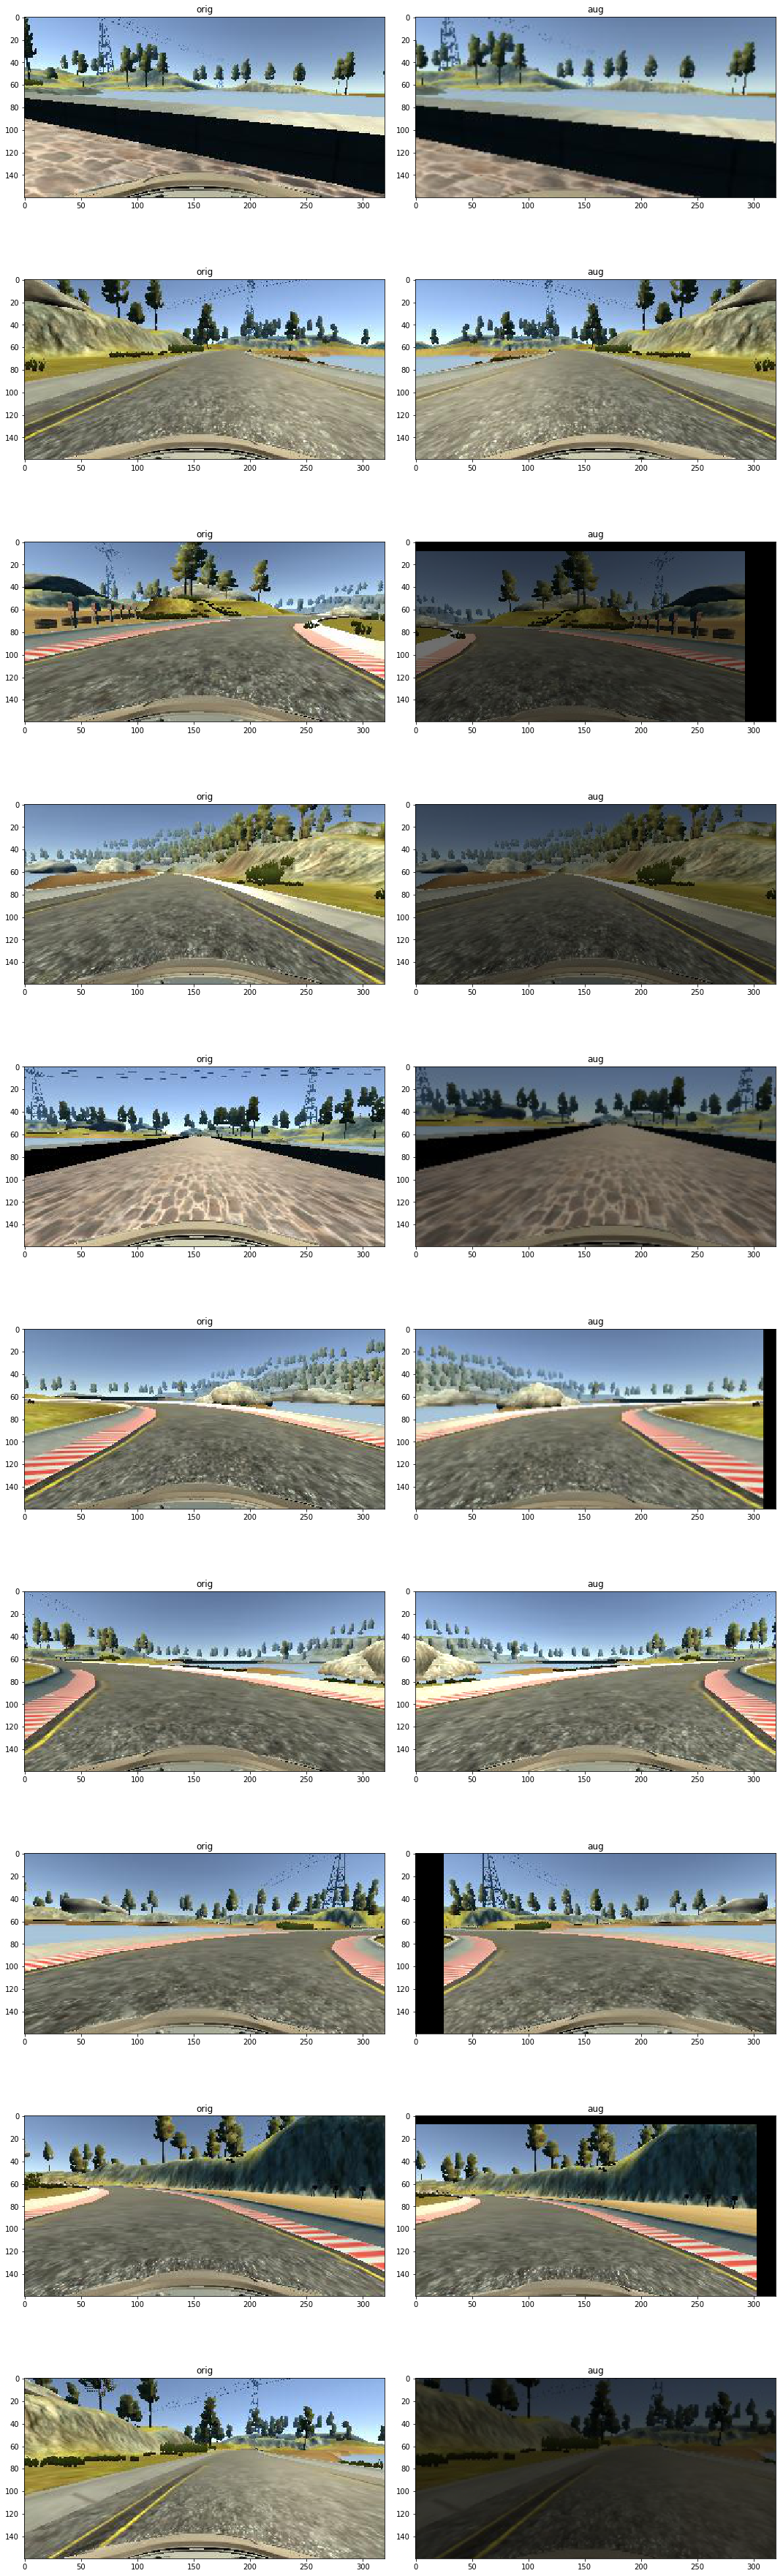

In [0]:
fig,axs = plt.subplots(10,2,figsize = (15,50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(img_path)-1)
  random_img = img_path[randnum]
  rand_steer = steering[randnum]
  
  orig_img = mpimg.imread(random_img)
  aug_img ,aug_steer = random_augment(random_img, rand_steer)
  
  axs[i][0].imshow(orig_img)
  axs[i][0].set_title('orig')
  
  axs[i][1].imshow(aug_img)
  axs[i][1].set_title('aug')
  
  


In [0]:
def batch_generator(img_path,steering,batch_size, istraining):
  while True:
    batch_img = []
    batch_steer = []

    for i in range(batch_size):
      random_ind = random.randint(0,len(img_path)-1)

      if  istraining:
        im ,steer = random_augment(img_path[random_ind],steering[random_ind])
      else:
        im = mpimg.imread(img_path[random_ind])
        steer = steering[random_ind]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steer.append(steer)
    yield(np.asarray(batch_img), np.asarray(batch_steer))

In [0]:
X_train_gen , y_train_gen = next(batch_generator(X_train,y_train,1,1))

X_valid_gen , y_valid_gen = next(batch_generator(X_valid,y_valid,1,0))

In [0]:
X_train_gen.shape
print(y_train)

[ 0.        -0.2007051  0.3993602 ...  0.4516532  0.        -1.       ]


Text(0.5, 1.0, 'Validation Image')

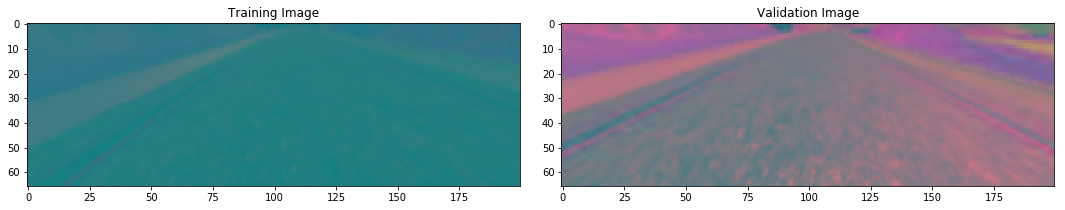

In [0]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(X_valid_gen[0])
axs[1].set_title('Validation Image')

In [0]:
def nvidia_model():
  model =Sequential()
  model.add(Convolution2D(24,5,5,subsample = (2,2),input_shape = (66,200,3) ,activation = 'elu'))
  model.add(Convolution2D(36,5,5,subsample = (2,2),activation = 'elu'))
  model.add(Convolution2D(48,5,5,subsample = (2,2),activation = 'elu'))
  model.add(Convolution2D(64,3,3,activation = 'elu'))
  model.add(Convolution2D(64,3,3,activation = 'elu'))
  
#   model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100,activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50,activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(10,activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  model.compile(loss = 'mse', optimizer = Adam(lr = 1e-4))
  
  return model

In [0]:
model = nvidia_model()
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)               115300    
__________

In [0]:
h = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 128s 425ms/step - loss: 0.1105 - val_loss: 0.0845
Epoch 2/10
300/300 [==============================] - 124s 415ms/step - loss: 0.0910 - val_loss: 0.0701
Epoch 3/10
300/300 [==============================] - 124s 413ms/step - loss: 0.0789 - val_loss: 0.0555
Epoch 4/10
300/300 [==============================] - 124s 413ms/step - loss: 0.0714 - val_loss: 0.0583
Epoch 5/10
300/300 [==============================] - 124s 413ms/step - loss: 0.0642 - val_loss: 0.0484
Epoch 6/10
300/300 [==============================] - 124s 414ms/step - loss: 0.0602 - val_loss: 0.0417
Epoch 7/10
300/300 [==============================] - 125s 416ms/step - loss: 0.0546 - val_loss: 0.0426
Epoch 8/10
300/300 [==============================] - 125s 416ms/step - loss: 0.0534 - val_loss: 0.0441
Epoch 9/10
300/300 [==============================] - 125s 417ms/step - loss: 0.0532 - val_loss: 0.0407
Epoch 10/10
300/300 [==============================] - 125s 416m

Text(0.5, 1.0, 'loss')

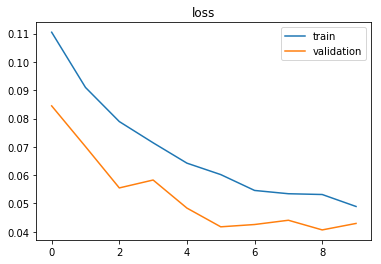

In [0]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['train','validation'])
plt.title('loss')

In [0]:
model.save('new_model1.h5')